In [ ]:
# default_exp models.esrnn.mqesrnn

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# MQESRNN model

> API details.

In [ ]:
# export
from nixtlats.models.esrnn.esrnn import ESRNN

In [ ]:
# export
class MQESRNN(ESRNN):
    def __init__(self,
                 n_series,
                 n_x,
                 n_s,
                 sample_freq,
                 input_size,
                 output_size,
                 es_component,
                 cell_type,
                 state_hsize,
                 dilations,
                 add_nl_layer,
                 learning_rate,
                 lr_scheduler_step_size,
                 lr_decay,
                 gradient_eps,
                 gradient_clipping_threshold,
                 rnn_weight_decay,
                 noise_std,
                 testing_percentiles,
                 training_percentiles,
                 loss,
                 val_loss):
        
        allowed_losses = ['MQ', 'wMQ']
        if loss not in allowed_losses:
            raise Exception(f'Loss {loss} not allowed')
            
        if val_loss is not None and val_loss not in allowed_losses:
            raise Exception(f'Val loss {val_loss} not allowed')
        
        allowed_es_component = ['median_residual', 'identity']
        
        if es_component not in allowed_es_component:
            raise Exception(f'es component {es_component} not allowed')
        
        level_variability_penalty = 0
        seasonality = []
        per_series_lr_multip = 1
        super(MQESRNN, self).__init__(n_series=n_series,
                                      n_s=n_s,
                                      n_x=n_x,
                                      sample_freq=sample_freq,
                                      input_size=input_size,
                                      output_size=output_size,
                                      es_component=es_component,
                                      cell_type=cell_type,
                                      state_hsize=state_hsize,
                                      dilations=dilations,
                                      add_nl_layer=add_nl_layer,
                                      seasonality=seasonality,
                                      learning_rate=learning_rate,
                                      lr_scheduler_step_size=lr_scheduler_step_size,
                                      lr_decay=lr_decay,
                                      per_series_lr_multip=per_series_lr_multip,
                                      gradient_eps=gradient_eps,
                                      gradient_clipping_threshold=gradient_clipping_threshold,
                                      rnn_weight_decay=rnn_weight_decay,
                                      noise_std=noise_std,
                                      level_variability_penalty=level_variability_penalty,
                                      testing_percentile=testing_percentiles,
                                      training_percentile=training_percentiles,
                                      loss=loss,
                                      val_loss=val_loss)

# Tests MQESRNN 

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch as t

from nixtlats.data.tsdataset import TimeSeriesDataset
from nixtlats.data.tsloader import TimeSeriesLoader

In [ ]:
n_ds = 100 
n_ts = 1_000

output_size = 2

uids = [f'uid_{i + 1}' for i in range(n_ts)]
dss = pd.date_range(end='2020-01-01', periods=n_ds)

Y_df = pd.DataFrame({'unique_id': np.repeat(uids, n_ds), 'ds': np.tile(dss, n_ts)})

In [ ]:
np.random.seed(10)
Y_df['y'] = Y_df.groupby('unique_id').transform(lambda x: np.random.uniform(1, 100, size=len(x)))

In [ ]:
Y_df = Y_df.sort_values(['unique_id', 'ds'])

In [ ]:
train_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  ds_in_test=3*output_size,
                                  is_test=False,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=True)

valid_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=False)

In [ ]:
train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=32,
                                eq_batch_size=True,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                batch_size=32,
                                shuffle=False)

In [ ]:
model = MQESRNN(n_series=train_dataset.n_series,
                n_s=train_dataset.n_s,
                n_x=train_dataset.n_x,
                #sample_freq=dataset.sample_freq,
                sample_freq=1,
                input_size=7*2,
                output_size=output_size,
                learning_rate=1e-2,
                lr_scheduler_step_size=30,
                lr_decay=0.1,
                gradient_eps=1e-8,
                gradient_clipping_threshold=10,
                rnn_weight_decay=0,
                noise_std=0.001,
                testing_percentiles=[30, 50, 70, 90],
                training_percentiles=[30, 50, 70, 90],
                es_component='median_residual',
                cell_type='LSTM',
                state_hsize=100,
                dilations=[[1, 2], [4, 8]],
                add_nl_layer=False,
                loss='MQ',
                val_loss='MQ')

In [ ]:
trainer = pl.Trainer(max_epochs=1, progress_bar_refresh_rate=5, deterministic=True)
trainer.fit(model, train_loader, valid_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type   | Params
---------------------------------
0 | esrnn | _ESRNN | 289 K 
---------------------------------
289 K     Trainable params
1         Non-trainable params
289 K     Total params
1.158     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/ubuntu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
outputs = trainer.predict(model, valid_loader)

/home/ubuntu/anaconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Predicting: 32it [00:00, ?it/s]

In [ ]:
y_true, y_hat, mask = zip(*outputs)
y_true = t.cat(y_true).numpy()
y_hat = t.cat(y_hat).numpy()
mask = t.cat(mask).numpy()

In [ ]:
y_true = y_true[-1000:, -1]
y_hat = y_hat[-1000:, -1]

calibration p30:  0.303
calibration p50:  0.49
calibration p70:  0.693
calibration p90:  0.952


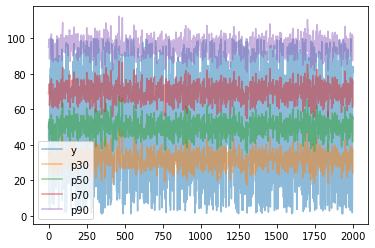

In [ ]:
plt.plot(y_true.flatten(), alpha=0.5, label='y')
for idx, p in enumerate([30, 50, 70, 90]):
    y_p = y_hat[:, :, idx]
    plt.plot(y_p.flatten(), alpha=0.5, label=f'p{p}')
    print(f'calibration p{p}: ', (y_true.flatten() <= y_p.flatten()).mean())
plt.legend()